# CMPT981 Project: Quantum Shortest Path

In [1]:
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import IntegerComparator
import numpy as np 
from tqdm import tqdm

## Section 1: Broda's algorithm
- For any algorithm to work, we want to have a valid data structure. 
- The purpose of this algorithm is to encode a classical array into a quantum circuit so that we can apply a Grover-based algorithm to it.
- I provided two versions of the same algorithm, one for demonstration purposes, the other with some very tiny optimization.

### Implementation of Broda's algorithm

In [71]:
MEM_SIZE = 4
MEM_MAX = 2 ** MEM_SIZE - 1
def QramCircuit(nums, s_mem = 4):
    size = len(nums)
    s_addr = int(np.ceil(np.log2(size)))

    qc = QuantumCircuit(s_addr + s_mem)

    lastflips = [0] * s_addr

    for i in range(size):
        val = nums[i]
        
        # change all 0 bits to 1

        # if j's bit is 1, flip it to 1
        t_addr = i
        for j in range(s_addr):
            flip = (t_addr & 1) == 1
            flip ^= lastflips[j]
            if flip:
                qc.x(j)
            t_addr >>= 1
        
        # apply multi-controlled-not gates to map address to memory
        t_val = val
        for j in range(s_mem):
            one = (t_val & 1)
            if one:
                qc.mct(list(range(s_addr)), s_addr + j)
            t_val >>= 1
        
        # flip back
        t_addr = i
        for j in range(s_addr):
            flip = (t_addr & 1) == 1
            lastflips[j] = flip
            t_addr >>= 1

    qc.name = 'Broda'

    return qc

In [72]:
def QramCircuit1(nums, s_mem = 4):
    size = len(nums)
    s_addr = int(np.ceil(np.log2(size)))

    qc = QuantumCircuit(s_addr + s_mem)

    for i in range(size):
        val = nums[i]
        
        # change all 0 bits to 1

        # if j's bit is 1, flip it to 1
        t_addr = i
        for j in range(s_addr):
            flip = (t_addr & 1) == 1
            if flip:
                qc.x(j)
            t_addr >>= 1
        
        # apply multi-controlled-not gates to map address to memory
        t_val = val
        for j in range(s_mem):
            one = (t_val & 1)
            if one:
                qc.mct(list(range(s_addr)), s_addr + j)
            t_val >>= 1
        
        # flip back
        t_addr = i
        for j in range(s_addr):
            flip = (t_addr & 1) == 1
            if flip:
                qc.x(j)
            t_addr >>= 1

        qc.barrier()

    qc.name = 'Broda'

    return qc

### Demonstration of Broda's algorithm
Here we want to encode a 4-item array [1, 4, 2, 5] into the circuit.\
q_0 and q_1 are address bits, q_2 to q_4 are memory bits.\
Since we have 4 items, we need log(4) = 2 address bits.\
Since the max is 5, to store a 5, we need ceil(log(5)) = 3 memory bits\
For each number in the array:
1. We flip the address bits to the current index
2. Depending on the numbers of 1's in the number's binary representation, we do multi-controlled-not(MCT) gates to map the address and memory bits.
3. We flip back the address bits.

For example, number 5 (binary: 101) is at index 3 (binary: 11).
1. Since the binary is 11, we flip both bits
2. Since 5 is 101, we have 1 at the first and third bits, so we apply two MCTs. The first MCT's target is the first memory bit (q_2), and the second MCT's target is the third memory bit (q_4)
3. Flip both bits back.

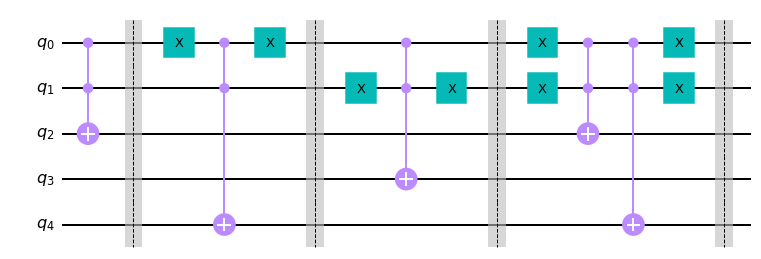

In [20]:
nums = [1, 4, 2, 5]
qram = QramCircuit1(nums, 3)
qram.draw('mpl')


Now, we want to test if Broda's circuit works.
1. We first apply Hadmard-gate on the address bits to create a superposition of all indices.
2. Then we apply Broda's circuit we construct from the previous block.
3. We measure all the memory bits.

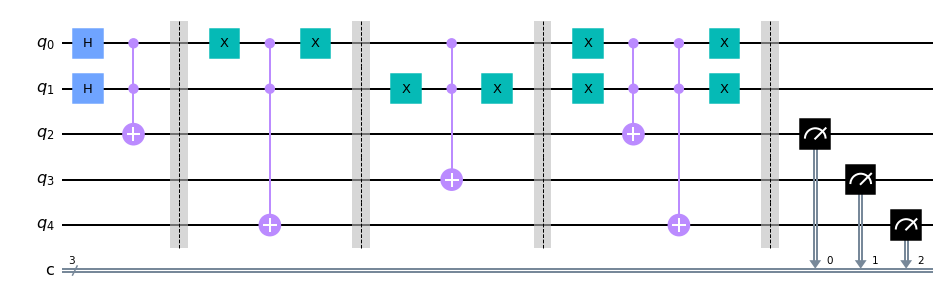

In [21]:
m = int(np.ceil(np.log2(len(nums))))

qc = QuantumCircuit(5, 3)
qc.h([0, 1])
qc = qc.compose(qram, [0, 1, 2, 3, 4])
qc.measure(qc.qubits[2:5], qc.clbits[:])
qc.draw('mpl')

Running the whole circuit in QSAM-simulator 1024 times, we can see the memory bits have almost equal probability for being [1, 2, 4, 5].\
We are confident now that Broda's algorithm works correctly.

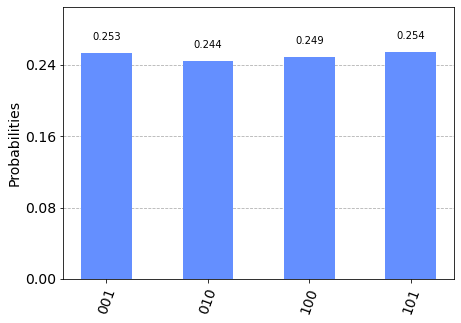

In [23]:
sim = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=sim, shots=1024).result().get_counts()
plot_histogram(counts)

## Section 2: Grover's algorithm
- In pathfinding algorithms, the most important step is to find the minimum values in an array.
- Grover's algorithm can search for items efficiently depending on the given oracle.
- We will use Grover's algorithm with a comparator oracle to find all the numbers in an array smaller than the given threshold.
- This will be our building block for finding the minimum value in an array.

### A typical diffuser circuit for Grover's algorithm
Here I use the diffuser implementation of qiskit

In [27]:
# https://qiskit.org/textbook/ch-algorithms/grover.html
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    for qubit in range(nqubits):
        qc.h(qubit)
    for qubit in range(nqubits):
        qc.x(qubit)
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1) 
    qc.h(nqubits-1)
    for qubit in range(nqubits):
        qc.x(qubit)
    for qubit in range(nqubits):
        qc.h(qubit)
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

### A custom comparator oracle used to find a number smaller than the given value.
Here I use IntegerComparator of qiskit

In [28]:
def comparator_oracle(n, value):
    qc = QuantumCircuit(n * 2 + 1)
    ic = IntegerComparator(num_state_qubits=n, geq=False, value=value)
    ici = ic.inverse()
    qc.append(ic, qc.qubits[:-1])
    qc.cx(n, n*2)
    qc.append(ici, qc.qubits[:-1])
    qc.name = f"cmp_{value}"
    return qc

### Implementation of Grover's algorithm

In [29]:
# https://qiskit.org/textbook/ch-algorithms/grover.html
def grover(arr_len, value):
    n = MEM_SIZE
    iter = max(int(np.pi / 4 * np.sqrt(arr_len)), 1)

    qc = QuantumCircuit(n * 2 + 1, n)
    qc.x(n * 2)
    qc.h(list(range(n)) + [n * 2])

    qc.barrier()

    for i in range(iter):
        qc.append(comparator_oracle(n, value))
        qc.append(diffuser(n), qc.qubits[0:n])

        qc.barrier()

    qc.measure(qc.qubits[0:n], qc.clbits[:])
    sim = Aer.get_backend('qasm_simulator')
    counts = execute(qc, backend=sim).result().get_counts()
    return int(list(counts.keys())[0], 2)

### Demonstration of Grover's algorithm
I am not going to explain Grover's algorithm here since it is complicated. I will simply demonstrate how it works.\
For the basic version of Grover's algorithm, we can only search for items in the whole space. For example, if we have 4 bits of space, we are searching for the numbers 0 - 16.\
Now, let's find all the numbers that are smaller than 5. 
1. We apply Hadmard-gate to put all 4 bits into superposition.
2. Apply the implementation in the previous blocks.
3. Measure the bits.

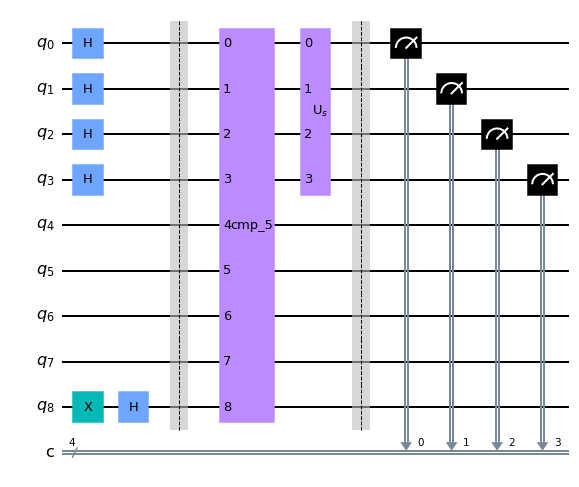

In [97]:
n = 4
value = 5
iter = int(np.pi / 4 * np.sqrt((2 ** n) / value))

qc = QuantumCircuit(n * 2 + 1, n)
qc.x(n * 2)
qc.h(list(range(n)) + [n * 2])

qc.barrier()
ic = comparator_oracle(n, value)
ici = ic.inverse()

for i in range(iter):
    qc.append(comparator_oracle(n, value), qc.qubits[0: n*2+1])
    qc.append(comparator_oracle(n, value), qc.qubits[0: n*2+1])
    qc.append(diffuser(n), qc.qubits[0:n])

    qc.barrier()

qc.measure(qc.qubits[0:n], qc.clbits[:])
qc.draw('mpl')

Running the whole circuit in QSAM-simulator 1024 times, the result shows the output probabilities for [0, 1, 2, 3, 4] are higher and the others are lower.\
Therefore, for this particular example, Grover's algorithm can find the answers.\
Notice that, Grover's algorithm is probabilistic and its success rate depends on the array size and answer size.\
In many cases, it is not guaranteed to be correct.

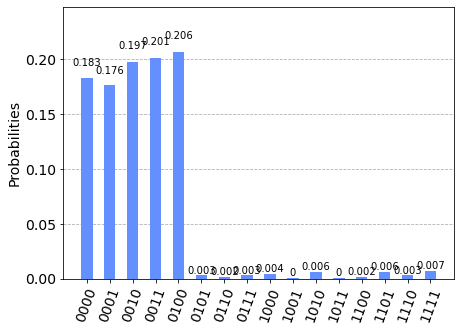

In [98]:
sim = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=sim, shots=1024).result().get_counts()
plot_histogram(counts)

### Extension of Grover's algorithm based on Broda's circuit
Since the basic version of Grover's algorithm can only search for items in the whole space. We extend it based on Broda's circuit so that it can search for items in the given Broda's circuit.

In [276]:
def groverQram(qram, arr_len, value):
    m = max(int(np.ceil(np.log2(arr_len))), 1)
    n = MEM_SIZE
    iter = max(int(np.pi / 4 * np.sqrt(arr_len)), 1)

    clen = m + n * 2
    qc = QuantumCircuit(clen, m)
    qc.x(clen - 1)
    qc.h(list(range(m)) + [clen - 1])

    ic = IntegerComparator(num_state_qubits=n, geq=False, value=value)

    qc.name = f"cmp_{value}"


    for i in range(iter):
        qc.append(qram, qc.qubits[0:m+n])
        qc.append(ic, qc.qubits[m: clen])
        qc.append(qram, qc.qubits[0:m+n])

        qc.append(diffuser(m), qc.qubits[0:m])


    qc.measure(qc.qubits[0:m], qc.clbits[:])
    
    sim = Aer.get_backend('qasm_simulator')
    counts = execute(qc, backend=sim).result().get_counts()
    return int(list(counts.keys())[0], 2)

### Demonstration of Grover's algorithm with Broda's circuit.
Here we combined Grover's circuit with Broda's circuit.\
In this case, we want to find the index of numbers smaller than 2 in array [11, 10, 0, 1, 5, 7, 9, 4], and we have the following circuit.

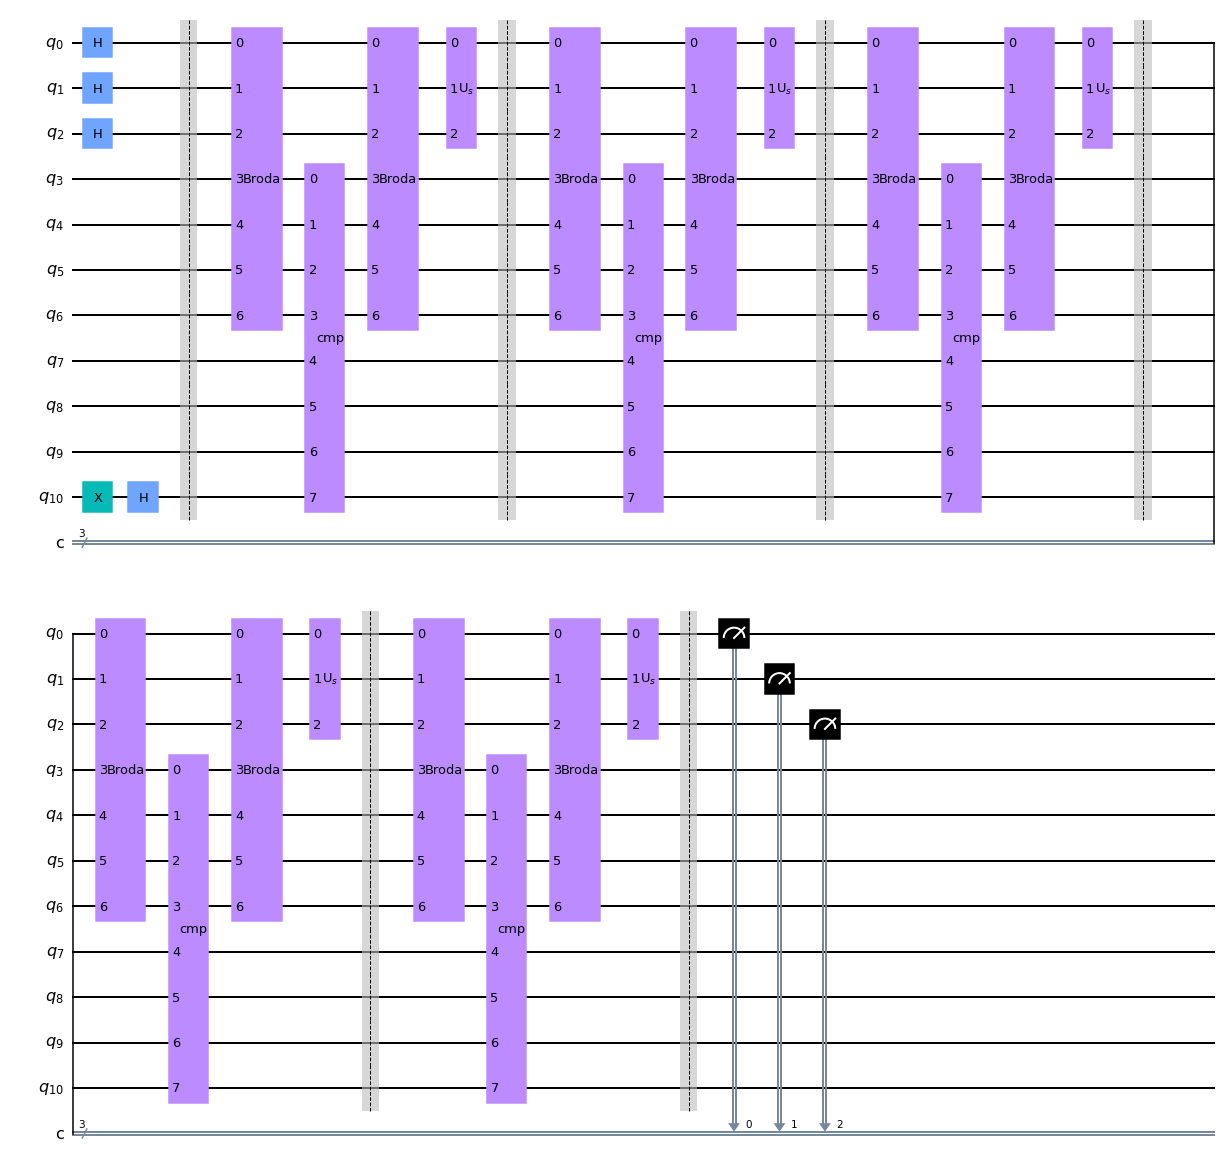

In [269]:
nums = [11, 10, 0, 1, 5, 7, 9, 4]
value = 2

n = 4
m = int(np.ceil(np.log2(len(nums))))
# iter = max(int(np.pi / 4 * np.sqrt(len(nums)/2)), 1)
# iter = max(int(np.pi / 4 * np.sqrt(2 ** n)), 1)
iter = 5

clen = m + n * 2
qc = QuantumCircuit(clen, m)
qc.x(clen - 1)
qc.h(list(range(m)) + [clen - 1])
# qc.barrier()

qram = QramCircuit(nums, 4)

ic = IntegerComparator(num_state_qubits=n, geq=False, value=value)

qc.name = f"cmp_{value}"


# qc.barrier()

for i in range(iter):
    
    qc.barrier()
    qc.append(qram, qc.qubits[0:m+n])
    qc.append(ic, qc.qubits[m: clen])
    qc.append(qram, qc.qubits[0:m+n])
    qc.append(diffuser(m), qc.qubits[0:m])



qc.barrier()

qc.measure(qc.qubits[0:m], qc.clbits[:])
qc.draw('mpl')

We use the classical method to find out the answer which is: [2(010), 3(011)]

In [267]:
ans = []
for i, v in enumerate(nums):
    if v < value:
        ans.append('{0:03b}'.format(i))
ans

['010', '011']

Running the whole circuit in QSAM-simulator 1024 times, the result shows the output probabilities for [2, 3] are slightly higher than the others.\
Notice that, Grover's algorithm did not work so well with Broder's circuit, and I have to manually tweak the iteration for it to work.\
However, this is OK. Durr and Hoyer's algorithm can still use this to find an array minimum with high probability.

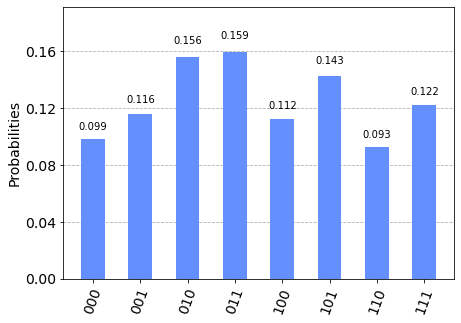

In [268]:
sim = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=sim, shots=1024).result().get_counts()
plot_histogram(counts)

## Section 3: Durr and Hoyer's algorithm
With the implementation of Broda's algorithm and Grover's algorithm, we can now construct an algorithm to find the array minimum.\
Similar to Grover's algorithm, I implemented two versions, one with Broda and one without, just for testing purposes.

In [271]:
def durrHoyer(nums, iter = None):
    n = len(nums)
    if n == 0:
        return
    if n == 1:
        return nums[0], 0
    if n == 2:
        return nums[0], 0 if nums[0] < nums[1] else nums[1], 1
        
    thres = np.random.randint(n)
    if iter is None:
        iter = int(22.5 * np.sqrt(n) + 1.4 * np.log2(n))
    gmin = thres
    print('running iter:', iter)
    for i in range(iter):
        nmin = grover(n, thres)
        if nmin < gmin:
            gmin = nmin
            thres = gmin
    return gmin

In [272]:
def durrHoyerQram(nums, iter = None):
    n = len(nums)
    if n == 0:
        return
    if n == 1:
        return nums[0], 0
    if n == 2:
        return (nums[0], 0) if nums[0] < nums[1] else (nums[1], 1)
        
    qram = QramCircuit(nums, MEM_SIZE)
    gargmin = np.random.randint(n)
    gmin = nums[gargmin]
    if iter is None:
        iter = int(22.5 * np.sqrt(n) + 1.4 * np.log2(n))
    print('running iter:', iter)
    for i in tqdm(range(iter)):
        argmin = groverQram(qram, n, gmin)
        if argmin >= n:
            continue
        nmin = nums[argmin]
        if nmin < gmin:
            gmin = nmin
            gargmin = argmin
    return gmin, gargmin

### Demonstration of Durr and Hoyer's algorithm
It is not very interesting to show Durr and Hoyer's algorithm without Broder's algorithm since the minimum will be always the first item.\
Therefore, here I only demonstrate the full version.\
In this case, we want to find the minimum of [11, 15, 10, 7, 9, 1, 0].\
The algorithm indeed returns the correct answer, item 0 at index 6.

In [278]:
# nums = [16, 16, 16, 16, 16, 16, 16, 16, 3, 16]
nums = [11, 15, 10, 7, 9, 1, 0]
durrHoyerQram(nums)

running iter: 63


100%|██████████| 63/63 [00:09<00:00,  6.45it/s]


(0, 6)

## Section 4: Pathfinding of DAG
Finally, we can use Durr and Hoyer's algorithm to construct the DAG shortest pathfinding algorithm.

In [279]:
def createDAG(adjm):
   # N is number of vertexes
   # M is number of edges

   inf = 2 ** MEM_SIZE - 1
   size = int(np.sqrt(len(adjm)))
   res = []
   
   for i in range(0, int(len(adjm) / size)):
      mslice = adjm[i * size : i * size + size]
      mslice = list(map(lambda x: inf if x == 0 else x, mslice))
      mslice[i] = 0
      res.append(mslice)

   return res

In [280]:
def QuantumShortestPath(adjm, s_index, d_index, repeat=False):
    n = len(adjm)
    s = 0
    h = [MEM_MAX] * n
    p = [np.inf] * n
    h[s] = 0
    iter = 1
    if repeat:
        iter = int(np.ceil(2 * np.log2(n)))

    for i in range(s + 1, n):
        for _ in range(iter):
            nums = [h[i]] + [min(h[j] + adjm[j][i], MEM_MAX) for j in range(i)]
            h[i], p[i] = durrHoyerQram(nums)
            p[i] -= 1

    cur = d_index
    path = [s_index]
    p_len = h[d_index]
    while cur != s_index:
        path.insert(1, cur)
        cur = p[cur]
    return {'path': path, 'length': p_len}

### Demonstration of DAG Pathfinding
Now, we can apply our algorithm to a simple DAG, which is given in an adjacency matrix.\
``` You could use this website to preview the DAG: https://graphonline.ru/en/. Select "0, 1, 2..." "Vertex enumeration", open "Graph", select "Adjacency Matrix", copy and paste the matrix below without square brackets, and click "Save" ```\
![alt text](.\DAG.png)\
Our purpose is to find the shortest path from the first vertex to the last vertex.\
With high probability, the algorithm will return the correct answer. (path: [0, 2, 3, 4] with length 4)

In [281]:
adjm = [
0, 2, 1, 4, 0, 
0, 0, 3, 2, 3, 
0, 0, 0, 1, 5, 
0, 0, 0, 0, 2, 
0, 0, 0, 0, 0
]
# adjm = [
# 0, 2, 3, 1, 0, 
# 0, 0, 0, 0, 3, 
# 0, 0, 0, 0, 1, 
# 0, 0, 0, 0, 1, 
# 0, 0, 0, 0, 0
# ]
adjm = createDAG(adjm)
QuantumShortestPath(adjm, 0, 4)

running iter: 41


100%|██████████| 41/41 [00:03<00:00, 10.86it/s]


running iter: 47


100%|██████████| 47/47 [00:04<00:00, 10.46it/s]


running iter: 53


100%|██████████| 53/53 [00:05<00:00,  9.89it/s]


{'path': [0, 2, 3, 4], 'length': 4}

## Reference
- Broda: https://arxiv.org/abs/1502.04943
- Grover: https://arxiv.org/abs/quant-ph/9605043
- Durr Hoyer: https://arxiv.org/abs/quant-ph/9607014
- Khadiev Safina: https://sfu-primo.hosted.exlibrisgroup.com/permalink/f/1u29dis/TN_cdi_proquest_journals_2219061161